In [25]:
import pandas as pd

# Cargar el archivo proporcionado
file_path = 'E:/Bootcamp/retail_sales_dataset.csv'  # Cambia esto si usas otro directorio
data = pd.read_csv(file_path)

# Explorar la estructura básica del dataset
data_info = {
    "Shape": data.shape,
    "Columns": data.columns.tolist(),
    "Missing Values": data.isnull().sum(),
    "Data Types": data.dtypes,
    "Sample Rows": data.head()
}

print(data_info)

{'Shape': (1000, 9), 'Columns': ['Transaction ID', 'Date', 'Customer ID', 'Gender', 'Age', 'Product Category', 'Quantity', 'Price per Unit', 'Total Amount'], 'Missing Values': Transaction ID      0
Date                0
Customer ID         0
Gender              0
Age                 0
Product Category    0
Quantity            0
Price per Unit      0
Total Amount        0
dtype: int64, 'Data Types': Transaction ID       int64
Date                object
Customer ID         object
Gender              object
Age                  int64
Product Category    object
Quantity             int64
Price per Unit       int64
Total Amount         int64
dtype: object, 'Sample Rows':    Transaction ID        Date Customer ID  Gender  Age Product Category  \
0               1  2023-11-24     CUST001    Male   34           Beauty   
1               2  2023-02-27     CUST002  Female   26         Clothing   
2               3  2023-01-13     CUST003    Male   50      Electronics   
3               4  2023-0

In [26]:
# Estadísticas descriptivas
descriptive_stats = data.describe(include='all')

# Detectar valores únicos en columnas categóricas y tipos mixtos
unique_values = {
    col: data[col].unique() if data[col].dtype == 'object' else None
    for col in data.columns
}

print(descriptive_stats)
print(unique_values)


        Transaction ID        Date Customer ID  Gender         Age  \
count      1000.000000        1000        1000    1000  1000.00000   
unique             NaN         345        1000       2         NaN   
top                NaN  2023-05-16    CUST1000  Female         NaN   
freq               NaN          11           1     510         NaN   
mean        500.500000         NaN         NaN     NaN    41.39200   
std         288.819436         NaN         NaN     NaN    13.68143   
min           1.000000         NaN         NaN     NaN    18.00000   
25%         250.750000         NaN         NaN     NaN    29.00000   
50%         500.500000         NaN         NaN     NaN    42.00000   
75%         750.250000         NaN         NaN     NaN    53.00000   
max        1000.000000         NaN         NaN     NaN    64.00000   

       Product Category     Quantity  Price per Unit  Total Amount  
count              1000  1000.000000     1000.000000   1000.000000  
unique               

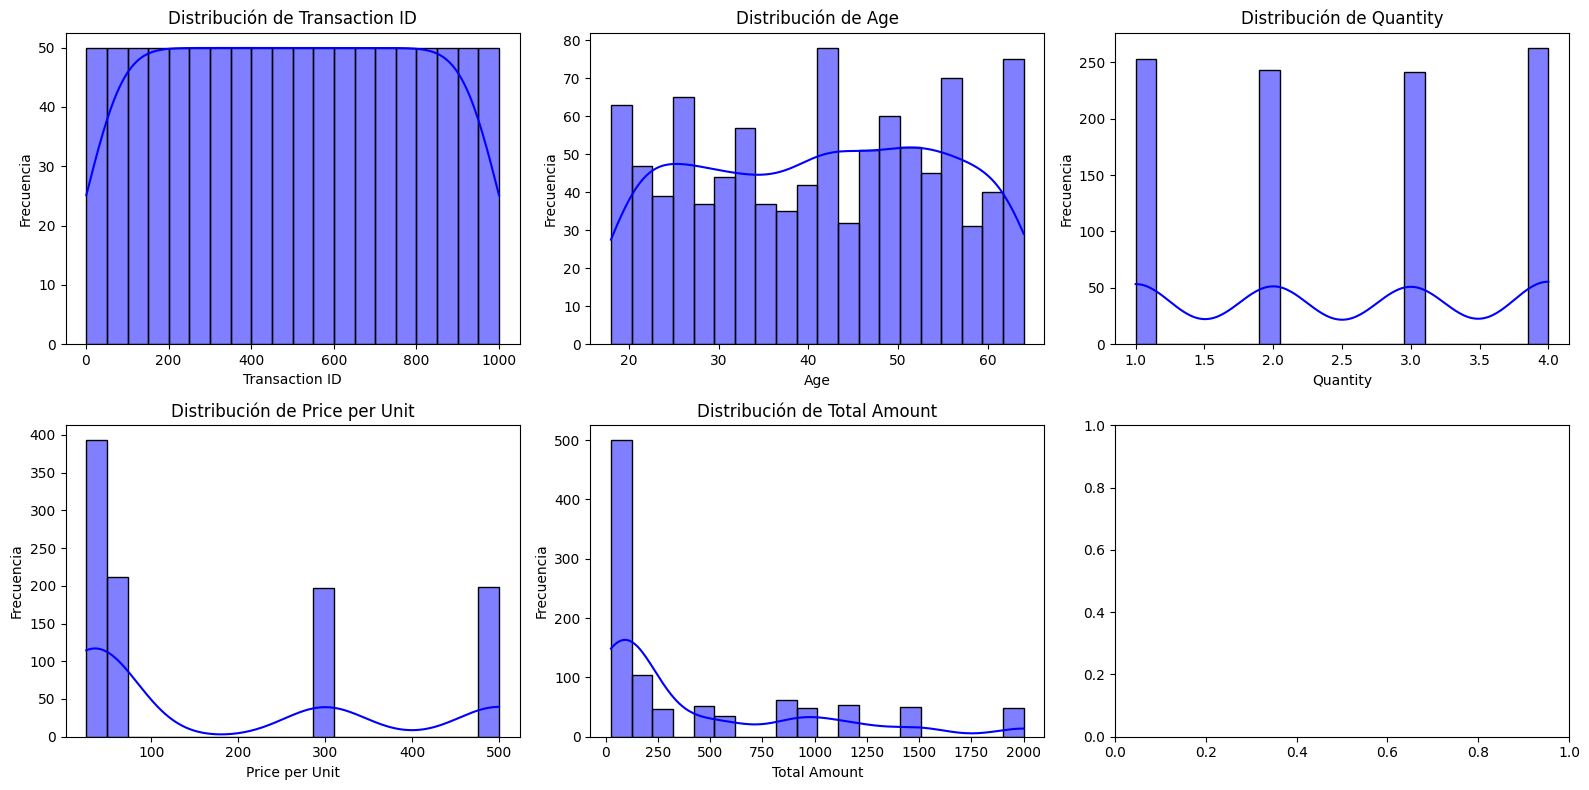

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico de distribución para variables numéricas
num_columns = data.select_dtypes(include=['int64', 'float64']).columns

fig, axes = plt.subplots(2, len(num_columns)//2 + len(num_columns)%2, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(num_columns):
    sns.histplot(data[col], kde=True, ax=axes[i], color="blue", bins=20)
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()



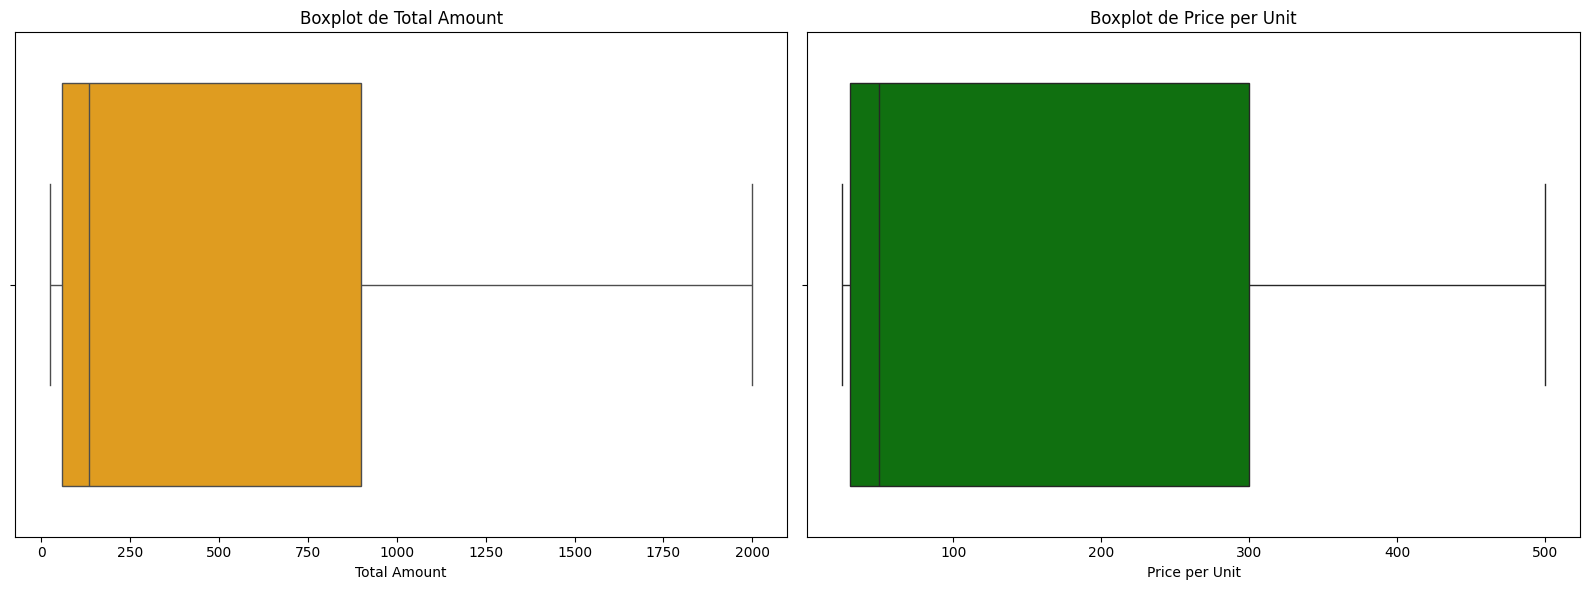

In [28]:
# Boxplots para detectar outliers en variables clave
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.boxplot(x=data['Total Amount'], ax=axes[0], color='orange')
axes[0].set_title('Boxplot de Total Amount')
sns.boxplot(x=data['Price per Unit'], ax=axes[1], color='green')
axes[1].set_title('Boxplot de Price per Unit')

plt.tight_layout()
plt.show()


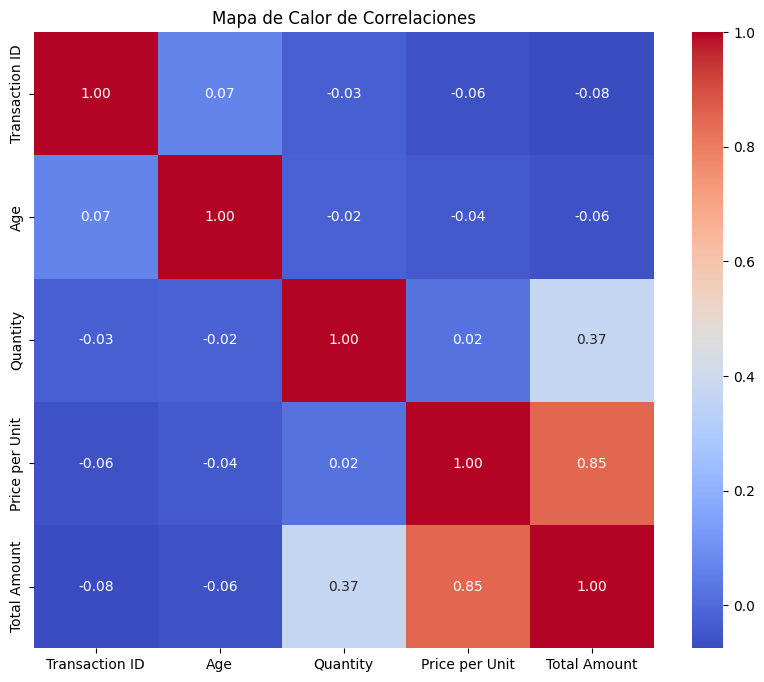

In [29]:
# Heatmap de correlación entre variables numéricas
correlation_matrix = data[num_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Mapa de Calor de Correlaciones')
plt.show()


In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Separar variables numéricas y categóricas
numerical_features = ['Age', 'Quantity', 'Price per Unit']
categorical_features = ['Gender', 'Product Category']

# Pipelines para cada tipo de columna
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Imputación de valores faltantes
    ('scaler', StandardScaler())  # Escalado estándar
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputación de valores faltantes
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Codificación OneHot
])

# Combinación en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ]
)

# Visualización de la transformación
print(preprocessor)


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'Quantity', 'Price per Unit']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Gender', 'Product Category'])])


In [31]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Separar X (features) e y (target)
X = data[['Age', 'Quantity', 'Price per Unit', 'Gender', 'Product Category']]
y = data['Total Amount']

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelos a probar
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor()
}

# Evaluación de modelos
results = {}
for model_name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    results[model_name] = {
        'CV Mean MSE': -np.mean(cv_scores),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'Test R2': r2_score(y_test, y_pred)
    }

# Mostrar resultados
for model, metrics in results.items():
    print(f"\n{model}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")



Linear Regression:
  CV Mean MSE: 47779.3784
  Test RMSE: 204.8924
  Test R2: 0.8566

Decision Tree:
  CV Mean MSE: -0.0000
  Test RMSE: 0.0000
  Test R2: 1.0000

Random Forest:
  CV Mean MSE: -0.0000
  Test RMSE: 0.0000
  Test R2: 1.0000


Classification Report:
              precision    recall  f1-score   support

          25       0.20      0.10      0.13        10
          30       0.00      0.00      0.00         7
          50       0.22      0.47      0.30        17
          60       0.00      0.00      0.00         9
          75       0.00      0.00      0.00         8
          90       0.00      0.00      0.00         9
         100       0.00      0.00      0.00        23
         120       0.27      0.43      0.33         7
         150       0.00      0.00      0.00         9
         200       0.48      0.76      0.59        17
         300       1.00      1.00      1.00        15
         500       1.00      1.00      1.00         8
         600       1.00      1.00      1.00         5
         900       1.00      1.00      1.00        14
        1000       1.00      1.00      1.00        12
        1200       1.00      1.00      1.00        10
        1500       1.00      1.00      1.00        13
    

c:\Users\chave\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chave\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chave\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

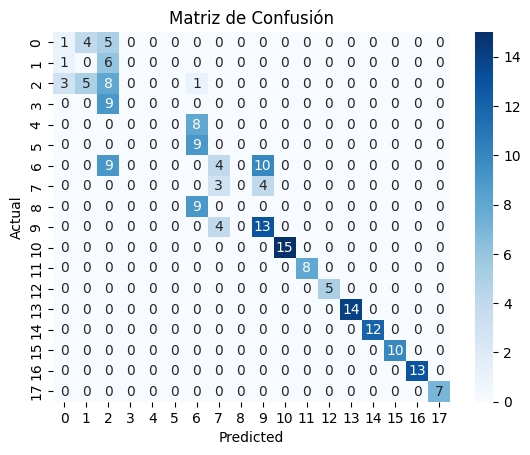

In [32]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Ejemplo con un modelo de clasificación (como LogisticRegression)
# Aquí reemplaza el modelo con uno de clasificación si lo estás usando.
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Generar informe
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [33]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binarizar las clases para problemas multiclase
classes = y_test.unique()
y_test_binarized = label_binarize(y_test, classes=classes)

# Obtener probabilidades de predicción (si tu modelo soporta predict_proba)
y_pred_proba = pipeline.predict_proba(X_test)

# Validar que el modelo sea multiclase
if y_pred_proba.shape[1] > 2:
    n_classes = len(classes)
else:
    raise ValueError("El modelo no parece ser multiclase.")


In [34]:
# Variables para almacenar curvas
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calcular para cada clase
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


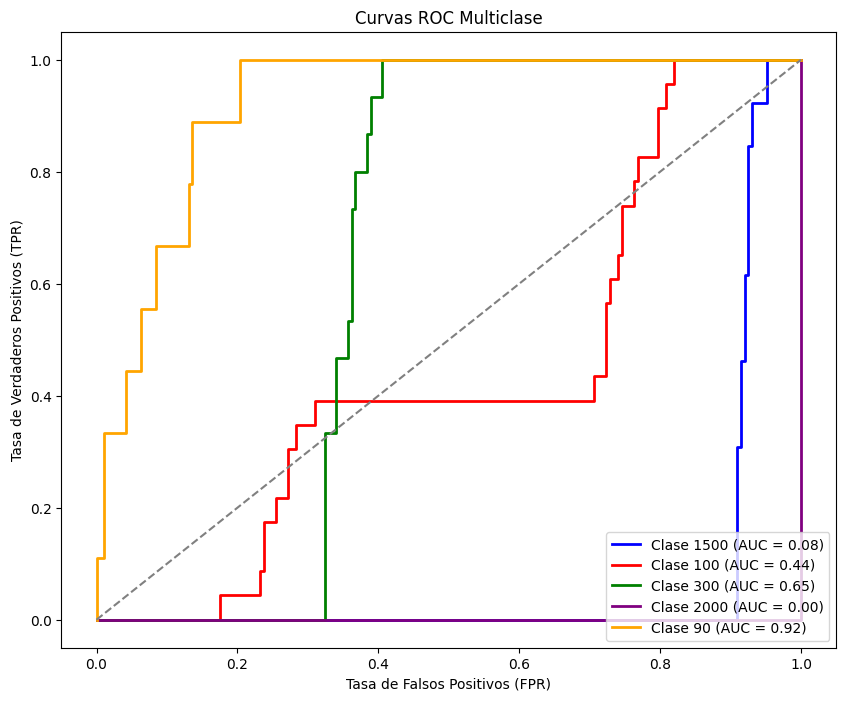

In [35]:
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange']  # Ajusta según el número de clases

for i, color in enumerate(colors[:n_classes]):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Clase {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Curvas ROC Multiclase')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc="lower right")
plt.show()
